In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import ppscore as pps
import xgboost as xgb

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split,GridSearchCV

# Read Data

In [3]:
data=pd.read_table("processed.cleveland.data",delimiter=",",header=None)

In [4]:
data.columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']

# Data Exploration

### Check for missing values

In [5]:
data.shape

(303, 14)

In [6]:
for i in data.columns:
    val=data[i].isnull().any()
    if val==True:
        print(val)

In [7]:
data=data[(data['ca']!='?')&(data['thal']!='?')]
data.shape

(297, 14)

### Is the target variable biased?

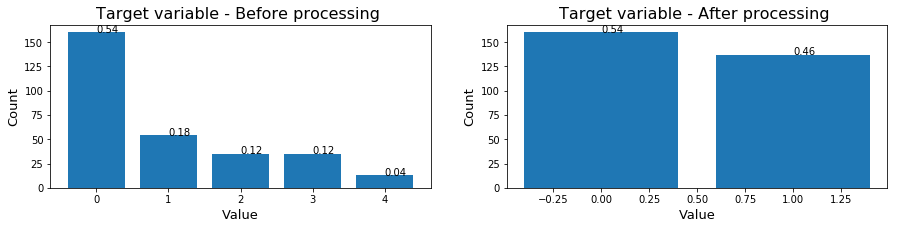

In [8]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(121)
plt.bar(data['num'].value_counts().index,data['num'].value_counts())
plt.title("Target variable - Before processing ",fontsize=16)
plt.xlabel("Value",fontsize=13)
plt.ylabel("Count",fontsize=13)
for x,y in zip(data['num'].value_counts().index,data['num'].value_counts()):
    val=np.round(y/data.shape[0],2)
    ax.annotate('%s' % val, xy=(x,y))

data['num']=np.where(data['num']!=0,1,0)
ax = fig.add_subplot(122)  
plt.bar(data['num'].value_counts().index,data['num'].value_counts())
plt.title("Target variable - After processing ",fontsize=16)
plt.xlabel("Value",fontsize=13)
plt.ylabel("Count",fontsize=13)
for x,y in zip(data['num'].value_counts().index,data['num'].value_counts()):
    val=np.round(y/data.shape[0],2)
    ax.annotate('%s' % val, xy=(x,y))

# Feature Selection

### Feature Selection based on Predictive Power Score

In [9]:
predictors=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
            'exang', 'oldpeak', 'slope', 'ca', 'thal']
target=['num']

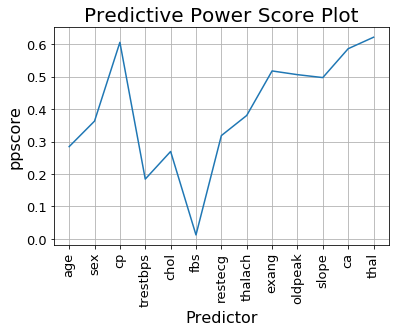

In [10]:
score=[]
var=[]
for i in predictors:
    score.append(pps.score(data,i,"num")['ppscore'])
    var.append(i)
    
ppscore_df=pd.DataFrame({'predictor':var,'ppscore':score})
ppscore_df.sort_values(['ppscore'],ascending=False)
plt.plot(ppscore_df['predictor'],ppscore_df['ppscore'])
plt.grid()
plt.xticks(rotation='vertical',fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("ppscore",fontsize=16)
plt.xlabel("Predictor",fontsize=16)
plt.title("Predictive Power Score Plot",fontsize=20)
plt.show()

In [11]:
(pps.matrix(data)).style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
age,1,0,0.00659182,0,0,0,0,0,0,0,0.00613339,0.0798981,0.00624488,0.0442477
sex,0.0480083,1,0,0.0459802,0.162099,0,0.0444769,0.181635,0,0.00454745,0,0,0,0
cp,0.123442,0.00014726,1,0.00809793,0,0.0571236,0,0.155479,0.205731,0.059515,0.0144633,0.00014726,0.192386,0.278708
trestbps,0,0,0,1,0,0,0,0,0,0,0,0,0,0
chol,0,0.0017449,0,0,1,0,0.00608871,0,0,0,0,0,0,0
fbs,0,0.000292695,0.000292695,0.0192132,0,1,0.000292695,0,0.000292695,0,0.000292695,0.000292695,0.000292695,0.000292695
restecg,0.232209,0.161697,0.350471,0.238455,0.26932,0.178074,1,0.242593,0.273966,0.186064,0.342029,0.288075,0.10818,0.361415
thalach,0.00278841,0,0.0764311,0,0,0,0,1,0.0844676,0,0.116921,0,0.05847,0.0870266
exang,0.0458553,7.80831e-05,0.407716,0.0704304,0.0144116,7.80831e-05,0,0.299371,1,0.225987,7.80831e-05,0.0208206,0.121333,0.386188
oldpeak,0,0,0.0524022,0,0,0,0,0,0.0344537,1,0.193843,0.0122281,0.0270854,0.0859604


In [12]:
ppscore_feature=list(ppscore_df['predictor'][ppscore_df['ppscore']>0.5])

### Feature Seelction based on Correlation

In [13]:
num_types=['int16','int32','int64','float16','float32','float64']
corr_col=data.select_dtypes(include=num_types).columns
corr_data=data[corr_col].corr()
corr_data.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num
age,1,-0.0923995,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.0964888,0.197123,0.159405,0.227075
sex,-0.0923995,1,0.00890803,-0.0663402,-0.198089,0.0388503,0.0338968,-0.060496,0.143581,0.106567,0.033345,0.278467
cp,0.110471,0.00890803,1,-0.0369797,0.0720883,-0.0576631,0.0639047,-0.339308,0.377525,0.203244,0.151079,0.408945
trestbps,0.290476,-0.0663402,-0.0369797,1,0.131536,0.18086,0.149242,-0.0491077,0.0666911,0.191243,0.121172,0.15349
chol,0.202644,-0.198089,0.0720883,0.131536,1,0.0127083,0.165046,-7.4568e-05,0.0593389,0.0385958,-0.00921524,0.0802848
fbs,0.132062,0.0388503,-0.0576631,0.18086,0.0127083,1,0.0688311,-0.00784236,-0.000893082,0.00831067,0.047819,0.00316683
restecg,0.149917,0.0338968,0.0639047,0.149242,0.165046,0.0688311,1,-0.0722896,0.0818739,0.113726,0.135141,0.166343
thalach,-0.394563,-0.060496,-0.339308,-0.0491077,-7.4568e-05,-0.00784236,-0.0722896,1,-0.384368,-0.34764,-0.389307,-0.423817
exang,0.0964888,0.143581,0.377525,0.0666911,0.0593389,-0.000893082,0.0818739,-0.384368,1,0.28931,0.250572,0.421355
oldpeak,0.197123,0.106567,0.203244,0.191243,0.0385958,0.00831067,0.113726,-0.34764,0.28931,1,0.579037,0.424052


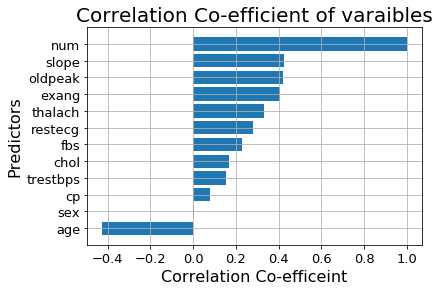

In [14]:
plt.barh(corr_data.columns,corr_data.iloc[-1].sort_values())
plt.title("Correlation Co-efficient of varaibles",fontsize=20)
plt.xlabel("Correlation Co-efficeint",fontsize=16)
plt.ylabel("Predictors",fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

In [15]:
corr_feature=list(corr_data.index[(corr_data.iloc[-1,:]>0.4)&((corr_data.iloc[-1,:]<1))])

### Feature Selection based on Accuracy

In [16]:
df=pd.DataFrame(data)
df.columns=[predictors+target]

In [17]:
def funct(predictors,target,data):
   
    X=data[predictors].values
    y=data[target].values
    y=y.astype('int')
    rf_class=RandomForestClassifier()
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=43)
    rf_class.fit(X_train,y_train)
    y_pred = rf_class.predict(X_test)
    acu=roc_auc_score(y_test,y_pred)
        
    return acu

In [18]:
acc_feature=[]
acc_list=[]
best_score=-1
for i in range(len(predictors)):
     
    pred=[predictors[:i+1]]
    accu=funct(pred,target,df)
    acc_list.append(accu)
    
    if accu>best_score:
        print(predictors[i],accu)
        acc_feature.append(predictors[i])
        best_score=accu

age 0.5714285714285715
sex 0.599702380952381
cp 0.742559523809524
chol 0.8050595238095238
oldpeak 0.8229166666666667


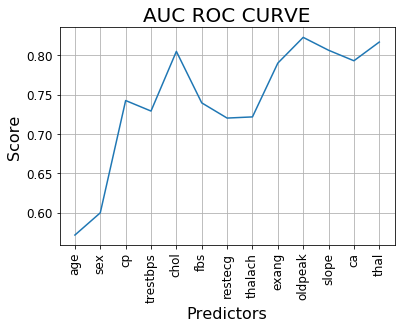

In [19]:
plt.plot(predictors,acc_list)
plt.xlabel("Predictors",fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Score",fontsize=16)
plt.title("AUC ROC CURVE",fontsize=20)
plt.grid()

In [20]:
print("Features selected by AUC:",acc_feature)

Features selected by AUC: ['age', 'sex', 'cp', 'chol', 'oldpeak']


In [21]:
print("Features selected by Correlation:",corr_feature)

Features selected by Correlation: ['cp', 'exang', 'oldpeak']


In [22]:
print("Features selected by Predictive Power Score:",ppscore_feature)

Features selected by Predictive Power Score: ['cp', 'exang', 'oldpeak', 'ca', 'thal']


In [23]:
def base_model(df,final_col,target):
    
    X=df[final_col].values
    y=(df[[target]])
    y=y.astype(int)
    Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=78)
    
    rf_base_model = RandomForestClassifier()
    rf_base_model.fit(Xtrain,ytrain)
    rf_base_predictions = rf_base_model.predict(Xtest)
    rf_acc=accuracy_score(rf_base_predictions,ytest)
    
    xgb_base_model = xgb.XGBClassifier()
    xgb_base_model.fit(Xtrain,ytrain)
    xgb_base_predictions = xgb_base_model.predict(Xtest)
    xgb_acc=accuracy_score(xgb_base_predictions,ytest)
    
    log_base_model = LogisticRegression()
    log_base_model.fit(Xtrain,ytrain)
    log_base_predictions = log_base_model.predict(Xtest)
    log_acc=accuracy_score(log_base_predictions,ytest)
    
    return rf_acc,xgb_acc,log_acc
    

In [24]:
target='num'
print("Accuracy for Correlation Features:",np.round(base_model(data,corr_feature,target),3))
print("Accuracy for Predictive Power Score Features:",np.round(base_model(data,ppscore_feature,target),3))
print("Accuracy for AUC Features:",np.round(base_model(data,acc_feature,target),3))

Accuracy for Correlation Features: [0.7   0.678 0.689]
Accuracy for Predictive Power Score Features: [0.756 0.778 0.822]
Accuracy for AUC Features: [0.7   0.744 0.733]


In [25]:
X=data[ppscore_feature].values
y=(data[[target]])
y=y.astype(int)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=43)

# Hyperparameter Optimization

In [26]:
rf_params = {
            'max_depth': [2,3,4,5], 
            'n_estimators': [30,40], 
            'max_features': np.arange(1,X.shape[1]+1),
            'min_samples_leaf': [5,10,15],
            'min_samples_split': [5,8],
            'max_leaf_nodes':[2,3,4],
            'random_state':[45]
            }
log_params = {
             'max_iter':[50,100],
             'multi_class':['warn'],
             'penalty':['l2'],
             'random_state':[45]
            }
xgb_params = {
            'max_depth': [2,3,4,5],  
            'max_features': np.arange(1,X.shape[1]+1),
            'min_samples_leaf': [5,10,15],
            'min_samples_split': [5,8],
            'max_leaf_nodes':[2,3,4],
            'random_state':[45]}
    
rf_model = RandomForestClassifier()
log_model = LogisticRegression()
xgb_model = xgb.XGBClassifier()

model_list=[rf_model,log_model,xgb_model]
params_list=[rf_params,log_params,xgb_params]
for i,j in zip(model_list,params_list):
    search = GridSearchCV(i, param_grid=j, cv=5, n_jobs=5, return_train_score=True)
    search.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       max_features=1, max_leaf_nodes=2, min_child_weight=1,
       min_samples_leaf=5, min_samples_split=5, missing=nan,
       monotone_constraints=None, n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=45,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

# Train Model

In [28]:
model=search.best_estimator_
predictions = model.predict(X_test)
confusion_matrix(predictions,y_test)

array([[43,  8],
       [ 5, 34]])

In [29]:
accuracy_score(predictions,y_test)

0.8555555555555555

In [30]:
search.best_params_

{'max_depth': 2,
 'max_features': 1,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'random_state': 45}

<BarContainer object of 5 artists>

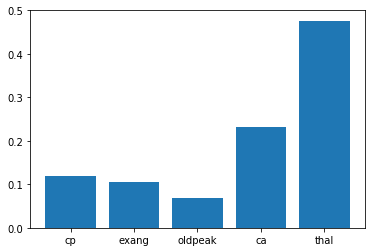

In [31]:
plt.bar(ppscore_feature,model.feature_importances_)